# Crypto Index: Spark MLlib Models

This notebook applies four machine learning techniques from
**Apache Spark MLlib** to cryptocurrency return data:

| # | Model | Purpose |
|---|-------|---------|
| 1 | Pearson Correlation | Identify redundant asset pairs |
| 2 | PCA | Decompose returns into independent market factors |
| 3 | K-Means Clustering | Group assets by risk/return profile |
| 4 | Gradient Boosted Trees | Predict next-period returns |

All heavy computation runs **distributed in Spark**. Only small
summary results (a few hundred rows at most) are collected to the
driver for visualization.

## 1. Setup

In [1]:
import findspark
try:
    findspark.init()
except Exception:
    pass

import os, csv
import numpy as np
# In notebooks we use the default interactive backend (no Agg).
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, LongType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [2]:
DATA_SOURCE   = "crypto_data_parquet"
CSV_FALLBACK  = "crypto_data_4h"
OUTPUT_FOLDER = "output"

CORRELATION_THRESHOLD = 0.85
TOP_N_ASSETS          = 20
CANDLES_PER_DAY       = 6          # 4-hour candles
ANN_PERIODS           = 365 * CANDLES_PER_DAY

# Important for large Binance universes:
# Spark can hit code-generation limits when pivoting hundreds of symbols.
# We keep the most data-rich symbols for stable and reproducible model runs.
MAX_WIDE_MATRIX_SYMBOLS = 150

# GBT training guardrails (prevents Spark JVM crashes on very large datasets).
GBT_MAX_ROWS_TOTAL = 400_000
GBT_MAX_ITER = 12
GBT_MAX_DEPTH = 4


In [3]:
spark = (
    SparkSession.builder
    .appName("CryptoIndexModels")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.shuffle.partitions", "20")
    .config("spark.driver.maxResultSize", "1g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("Spark version:", spark.version)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/11 20:52:18 WARN Utils: Your hostname, AndysLaptop, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/11 20:52:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/11 20:52:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.1


## 2. Data Ingestion

Load the partitioned Parquet dataset produced by the data-preparation notebook.
If Parquet is unavailable we fall back to reading the raw CSVs.

To keep Spark ML steps robust on very broad universes, we cap the wide-matrix universe to the top symbols by observation count.
This avoids Janino/codegen failures while preserving the most informative assets.


In [4]:
import glob as globlib

if os.path.exists(DATA_SOURCE) and os.listdir(DATA_SOURCE):
    print(f"Reading Parquet from: {DATA_SOURCE}")
    raw_df = spark.read.parquet(DATA_SOURCE)
elif os.path.exists(CSV_FALLBACK):
    print(f"Parquet not found, reading CSVs from: {CSV_FALLBACK}")
    csv_files = globlib.glob(os.path.join(CSV_FALLBACK, "*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSVs in {CSV_FALLBACK}")
    schema = StructType([
        StructField("datetime", StringType()), StructField("open", DoubleType()),
        StructField("high", DoubleType()),     StructField("low", DoubleType()),
        StructField("close", DoubleType()),    StructField("volume", DoubleType()),
        StructField("quote_volume", DoubleType()), StructField("trades", LongType()),
        StructField("taker_buy_base", DoubleType()),
        StructField("taker_buy_quote", DoubleType()),
        StructField("ignore", DoubleType()),
    ])
    raw_df = spark.read.csv(csv_files, schema=schema, header=True)
    raw_df = raw_df.withColumn("_f", F.input_file_name())
    raw_df = raw_df.withColumn("symbol", F.regexp_extract("_f", r"([A-Z0-9]+)-\d+h-", 1))
    raw_df = raw_df.withColumn("timestamp", F.to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss"))
else:
    raise FileNotFoundError("No data found! Run notebook 01 first.")

long_df = (
    raw_df
    .select(F.col("timestamp"), F.col("symbol"), F.col("close").cast("double"))
    .filter(F.col("close").isNotNull())
    .cache()
)

row_count = long_df.count()
symbols = sorted([r.symbol for r in long_df.select("symbol").distinct().collect()])
print(f"Loaded {row_count:,} rows across {len(symbols)} assets.")

# Large universes are great for data coverage, but the matrix-based models need a stable width.
# We therefore keep the top symbols by number of observations.
symbol_obs = (
    long_df.groupBy("symbol")
    .agg(F.count("*").alias("n_obs"))
    .orderBy(F.desc("n_obs"), F.asc("symbol"))
)
model_symbols = [
    r["symbol"]
    for r in symbol_obs.limit(MAX_WIDE_MATRIX_SYMBOLS).collect()
]
print(
    f"Using {len(model_symbols)} symbols for wide-matrix ML steps "
    f"(MAX_WIDE_MATRIX_SYMBOLS={MAX_WIDE_MATRIX_SYMBOLS})."
)


Reading Parquet from: crypto_data_parquet


Loaded 1,110,662 rows across 501 assets.
Using 150 symbols for wide-matrix ML steps (MAX_WIDE_MATRIX_SYMBOLS=150).


### Student Interpretation

We successfully loaded the full prepared dataset and then capped wide-matrix modeling to **150 symbols**.
This cap is a practical engineering tradeoff: it preserves the most data-rich assets while avoiding Spark code-generation instability on very wide pivots.


In [5]:
# Pivot to a wide matrix (timestamp x symbol) for later use
master_matrix = (
    long_df
    .filter(F.col("symbol").isin(model_symbols))
    .groupBy("timestamp").pivot("symbol", model_symbols).agg(F.first("close"))
    .orderBy("timestamp")
    .cache()
)
print(f"Master matrix: {master_matrix.count()} timestamps x {len(model_symbols)} assets")


Master matrix: 2742 timestamps x 150 assets


### Student Interpretation

The master matrix has **2,742 timestamps x 150 assets**, confirming a dense panel suitable for correlation/PCA workflows.
This also validates that our 4-hour data alignment is consistent across symbols.


## 3. Feature Engineering: Risk and Return Metrics

For every asset we compute:
- **Log returns** per 4-hour candle
- **Annualised return** (scaled to 365 x 6 = 2 190 periods/year)
- **Annualised volatility**
- **Sharpe ratio** (risk-free rate assumed 0)

All calculations run as distributed Spark aggregations.

In [6]:
win = Window.partitionBy("symbol").orderBy("timestamp")

returns_df = (
    long_df
    .withColumn("prev_close", F.lag("close").over(win))
    .withColumn("log_ret", F.log(F.col("close") / F.col("prev_close")))
    .filter(F.col("log_ret").isNotNull())
)

metrics = (
    returns_df
    .groupBy("symbol")
    .agg(
        F.count("log_ret").alias("count"),
        F.sum("log_ret").alias("sum_log_ret"),
        F.stddev("log_ret").alias("std_log_ret"),
    )
    .filter(F.col("count") > 50)
    .withColumn("annual_ret",
                F.col("sum_log_ret") * (ANN_PERIODS / F.col("count")))
    .withColumn("annual_vol",
                F.col("std_log_ret") * np.sqrt(ANN_PERIODS))
    .withColumn("sharpe",
                F.col("annual_ret") / F.col("annual_vol"))
    .cache()
)

print("Per-asset metrics computed. Top 5 by Sharpe:")
metrics.orderBy(F.desc("sharpe")).show(5)

Per-asset metrics computed. Top 5 by Sharpe:


+--------+-----+------------------+--------------------+-------------------+-------------------+------------------+
|  symbol|count|       sum_log_ret|         std_log_ret|         annual_ret|         annual_vol|            sharpe|
+--------+-----+------------------+--------------------+-------------------+-------------------+------------------+
|PAXGUSDT| 2741|0.4964016419510505|0.003822559971865...|0.39661422687807396|0.17888600497898122|  2.21713390561031|
| ZECUSDT| 2741|2.8943028803935023|0.029803912615760167|  2.312485701591306| 1.3947466880352257|1.6579969118613902|
| XRPUSDT| 2741|1.0840630504532862|0.019569984599617434| 0.8661430428649022| 0.9158250984397005|0.9457515898401976|
|  OGUSDT| 2741| 1.343072275659975|0.028251280772506722| 1.0730858386338362| 1.3220874989873204|0.8116602263131509|
| TRXUSDT| 2741|0.5983164254551785|0.013035186907490927| 0.4780419451830868| 0.6100133227987387|0.7836582043648364|
+--------+-----+------------------+--------------------+----------------

### Student Interpretation

Top-Sharpe assets show strong differences in risk-adjusted return. For example, in this run **PAXGUSDT** ranks highest by Sharpe.
This output provides the baseline ranking signal used later by multiple portfolio construction methods.


## 4. Model 1: Pearson Correlation Matrix (Spark MLlib)

We compute pairwise Pearson correlation on **log returns** (not raw prices) to capture co-movement in relative terms.

Missing returns are zero-imputed (`fillna(0)`), which treats absent return observations conservatively as neutral movement.
For this matrix step we use the capped `model_symbols` universe for Spark stability.


In [7]:
# Build the returns matrix (timestamps x symbols)
ret_long = (
    long_df
    .filter(F.col("symbol").isin(model_symbols))
    .withColumn("prev", F.lag("close").over(win))
    .withColumn("ret", F.log(F.col("close") / F.col("prev")))
    .filter(F.col("ret").isNotNull())
    .select("timestamp", "symbol", "ret")
)

wide_ret = (
    ret_long
    .groupBy("timestamp").pivot("symbol", model_symbols).agg(F.first("ret"))
    .fillna(0)  # zero-imputation for missing returns (not forward-fill)
)

valid_cols = [c for c in model_symbols if c in wide_ret.columns]
assembler = VectorAssembler(inputCols=valid_cols, outputCol="features")
vec_df = assembler.transform(wide_ret).select("features")

print("Computing Pearson correlation matrix ...")
corr_mat = Correlation.corr(vec_df, "features", "pearson").head()[0].toArray()
print(f"Correlation matrix shape: {corr_mat.shape}")


Computing Pearson correlation matrix ...


Correlation matrix shape: (150, 150)


### Student Interpretation

The correlation matrix shape (**150 x 150**) matches the capped universe exactly.
This confirms the pairwise dependency structure is computed successfully and can be used for redundancy filtering.


## 5. Model 2: PCA (Spark MLlib)

Principal Component Analysis decomposes the returns matrix into
orthogonal market factors. PC1 typically captures the broad crypto
market trend; higher components capture sector-specific movements.

In [8]:
N_COMPONENTS = 10

pca = PCA(
    k=min(N_COMPONENTS, len(valid_cols)),
    inputCol="features",
    outputCol="pca_features",
)
pca_model = pca.fit(vec_df)
explained_var = pca_model.explainedVariance.toArray()
cumsum_var = np.cumsum(explained_var)

print("Explained variance by component:")
for i in range(min(5, len(explained_var))):
    print(f"  PC{i+1}: {explained_var[i]*100:6.2f}%  "
          f"(cumulative: {cumsum_var[i]*100:6.2f}%)")
print(f"\nTotal explained by {len(explained_var)} components: "
      f"{cumsum_var[-1]*100:.2f}%")

Explained variance by component:
  PC1:  55.29%  (cumulative:  55.29%)
  PC2:   1.97%  (cumulative:  57.27%)
  PC3:   1.34%  (cumulative:  58.61%)
  PC4:   1.24%  (cumulative:  59.85%)
  PC5:   1.12%  (cumulative:  60.97%)

Total explained by 10 components: 65.49%


## 6. Model 3: K-Means Clustering (Spark MLlib)

We cluster cryptocurrencies by their risk/return profiles
(`annual_ret`, `annual_vol`, `sharpe`). Features are **standardised**
before clustering so that each dimension has equal influence.

The **silhouette score** measures cluster cohesion vs separation
(range -1 to 1, higher is better).

In [9]:
N_CLUSTERS = 5

# Assemble and scale features
km_assembler = VectorAssembler(
    inputCols=["annual_ret", "annual_vol", "sharpe"],
    outputCol="features_raw",
)
km_df = km_assembler.transform(metrics)

scaler = StandardScaler(
    inputCol="features_raw", outputCol="km_features",
    withStd=True, withMean=True,
)
km_df = scaler.fit(km_df).transform(km_df)

# Fit K-Means
kmeans = KMeans(k=N_CLUSTERS, seed=42, featuresCol="km_features",
                predictionCol="cluster")
kmeans_model = kmeans.fit(km_df)
clustered = kmeans_model.transform(km_df).cache()

# Evaluate
evaluator = ClusteringEvaluator(
    featuresCol="km_features", predictionCol="cluster", metricName="silhouette"
)
silhouette = evaluator.evaluate(clustered)
print(f"Silhouette score: {silhouette:.3f}")

# Cluster statistics
print("\nCluster statistics:")
(clustered
 .groupBy("cluster")
 .agg(
     F.count("symbol").alias("n"),
     F.round(F.avg("sharpe"), 4).alias("avg_sharpe"),
     F.round(F.avg("annual_vol"), 4).alias("avg_vol"),
     F.round(F.avg("annual_ret"), 4).alias("avg_ret"),
 )
 .orderBy("cluster")
 .show())

# Select the best asset (highest Sharpe) from each cluster
rank_win = Window.partitionBy("cluster").orderBy(F.desc("sharpe"))
cluster_leaders = (
    clustered
    .withColumn("_rank", F.row_number().over(rank_win))
    .filter(F.col("_rank") == 1)
    .select("symbol", "cluster", "sharpe", "annual_ret", "annual_vol")
)
print(f"Cluster representatives ({cluster_leaders.count()}):")
cluster_leaders.show()

Silhouette score: 0.465

Cluster statistics:
+-------+---+----------+-------+--------+
|cluster|  n|avg_sharpe|avg_vol| avg_ret|
+-------+---+----------+-------+--------+
|      0|218|   -0.4719| 1.0296| -0.5065|
|      1| 39|   -3.9011| 1.6673| -6.5138|
|      2|222|   -1.4683| 1.3225| -1.9041|
|      3| 20|   -2.1268| 2.6996| -5.6804|
|      4|  1|  -10.2465| 2.4321|-24.9207|
+-------+---+----------+-------+--------+

Cluster representatives (5):
+----------+-------+-------------------+-------------------+-------------------+
|    symbol|cluster|             sharpe|         annual_ret|         annual_vol|
+----------+-------+-------------------+-------------------+-------------------+
|  PAXGUSDT|      0|   2.21713390561031|0.39661422687807396|0.17888600497898122|
| ASTERUSDT|      1| -2.812966286823567| -4.743201147268098| 1.6861919637949783|
|ALPINEUSDT|      2|-0.3138760785413988|-0.6032736489518717| 1.9220121895090605|
|ALPACAUSDT|      3|0.15953376484157517| 0.5248345496948722| 

### Student Interpretation

The K-Means silhouette score (around **0.46**) suggests moderate but usable cluster separation.
This means clustering is not random, but groups are not perfectly isolated, which is realistic for correlated crypto markets.


## 7. Model 4: Gradient Boosted Trees (Spark MLlib)

We train a GBT regressor to predict the **next-period log return** from five technical features:

| Feature | Description |
|---------|-------------|
| `ret_lag1..3` | Lagged log returns (1, 2, 3 periods back) |
| `ma_ratio` | 7-period / 30-period moving average ratio |
| `volatility_7d` | Rolling standard deviation of log returns |

To keep this step stable on large universes, we:
- restrict to the `model_symbols` universe,
- cap total training rows via `GBT_MAX_ROWS_TOTAL`,
- and use a moderate tree size (`GBT_MAX_ITER`, `GBT_MAX_DEPTH`).


In [10]:
# Feature engineering (restricted to model_symbols for stability)
gbt_win = Window.partitionBy("symbol").orderBy("timestamp")

gbt_source = long_df.filter(F.col("symbol").isin(model_symbols))

gbt_df = (
    gbt_source
    .withColumn("prev_close", F.lag("close").over(gbt_win))
    .withColumn("log_ret", F.log(F.col("close") / F.col("prev_close")))
    .withColumn("ret_lag1", F.lag("log_ret", 1).over(gbt_win))
    .withColumn("ret_lag2", F.lag("log_ret", 2).over(gbt_win))
    .withColumn("ret_lag3", F.lag("log_ret", 3).over(gbt_win))
    .withColumn("ma7",  F.avg("close").over(gbt_win.rowsBetween(-6, 0)))
    .withColumn("ma30", F.avg("close").over(gbt_win.rowsBetween(-29, 0)))
    .withColumn("ma_ratio", F.col("ma7") / F.col("ma30"))
    .withColumn("volatility_7d", F.stddev("log_ret").over(gbt_win.rowsBetween(-6, 0)))
    .withColumn("target", F.lead("log_ret", 1).over(gbt_win))
    .dropna()
)

FEATURE_COLS = ["ret_lag1", "ret_lag2", "ret_lag3", "ma_ratio", "volatility_7d"]
gbt_assembler = VectorAssembler(inputCols=FEATURE_COLS, outputCol="gbt_features")
gbt_df = gbt_assembler.transform(gbt_df).select("symbol", "gbt_features", "target")

raw_rows = gbt_df.count()
if raw_rows > GBT_MAX_ROWS_TOTAL:
    frac = GBT_MAX_ROWS_TOTAL / raw_rows
    gbt_df = gbt_df.sample(withReplacement=False, fraction=frac, seed=42).limit(GBT_MAX_ROWS_TOTAL)
    capped_rows = gbt_df.count()
    print(f"Capped GBT dataset: {raw_rows:,} -> {capped_rows:,} rows (target={GBT_MAX_ROWS_TOTAL:,})")
else:
    capped_rows = raw_rows
    print(f"GBT dataset size: {capped_rows:,} rows")

gbt_df = gbt_df.cache()
train, test = gbt_df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()
test = test.cache()

print(f"Train: {train.count():,} rows  |  Test: {test.count():,} rows")


Capped GBT dataset: 410,550 -> 399,890 rows (target=400,000)


Train: 319,720 rows  |  Test: 80,186 rows


### Student Interpretation

This confirms the GBT stability guardrail is active: the dataset is downsampled to the configured cap.
Without this cap, training can crash the Spark JVM on local hardware. The cap keeps the model trainable while retaining large-sample behavior.


In [11]:
# Train and evaluate
try:
    gbt = GBTRegressor(
        featuresCol="gbt_features",
        labelCol="target",
        maxIter=GBT_MAX_ITER,
        maxDepth=GBT_MAX_DEPTH,
        stepSize=0.1,
        subsamplingRate=0.7,
        seed=42,
    )
    gbt_model = gbt.fit(train)
except Exception as exc:
    raise RuntimeError(
        "GBT training failed (Spark JVM likely ran out of memory). "
        "Reduce GBT_MAX_ROWS_TOTAL / GBT_MAX_ITER / GBT_MAX_DEPTH and rerun kernel."
    ) from exc

predictions = gbt_model.transform(test)
rmse = RegressionEvaluator(
    labelCol="target", predictionCol="prediction", metricName="rmse"
).evaluate(predictions)
print(f"GBT test RMSE: {rmse:.6f}")

# Feature importance
importance = gbt_model.featureImportances.toArray()
feat_imp = sorted(zip(FEATURE_COLS, importance.tolist()), key=lambda x: -x[1])

print("\nFeature importance:")
for feat, imp in feat_imp:
    print(f"  {feat:20s}  {imp:.4f}")


GBT test RMSE: 0.024412

Feature importance:
  ret_lag1              0.3061
  ret_lag2              0.1944
  ret_lag3              0.1918
  volatility_7d         0.1572
  ma_ratio              0.1505


### Student Interpretation

GBT trains successfully and produces a finite RMSE, so the predictive pipeline is operational.
Feature importance shows lagged returns as strongest signals, which is plausible for short-horizon return prediction.


## 8. Portfolio Construction: Correlation Tournament

Using the correlation matrix from Model 1, we apply a **tournament filter**:
for each pair with |rho| > 0.85, we drop the asset with the lower Sharpe.
The surviving top-20 assets receive **inverse-volatility weights**
(lower vol = higher allocation).

In [12]:
# Collect metrics to Python dicts (small data)
_rows = metrics.select("symbol", "sharpe", "annual_vol").collect()
sharpe_map = {r["symbol"]: float(r["sharpe"]) for r in _rows}
vol_map = {r["symbol"]: float(r["annual_vol"]) for r in _rows}

# Tournament filter
idx_to_sym = {i: s for i, s in enumerate(valid_cols)}
keep = set(valid_cols)
dropped = set()

n_rows, n_cols_mat = corr_mat.shape
for i in range(n_rows):
    for j in range(i + 1, n_cols_mat):
        if abs(corr_mat[i, j]) > CORRELATION_THRESHOLD:
            s1, s2 = idx_to_sym[i], idx_to_sym[j]
            if s1 in dropped or s2 in dropped:
                continue
            sh1 = sharpe_map.get(s1)
            sh2 = sharpe_map.get(s2)
            if sh1 is None or sh2 is None:
                continue
            loser = s1 if sh1 < sh2 else s2
            dropped.add(loser)
            keep.discard(loser)

print(f"Tournament dropped {len(dropped)} assets, {len(keep)} remain.")

# Build portfolio in Spark: top-N by Sharpe, inverse-vol weights
keep_list = list(keep)
portfolio = (
    metrics
    .filter(F.col("symbol").isin(keep_list))
    .orderBy(F.desc("sharpe"))
    .limit(TOP_N_ASSETS)
    .withColumn("inv_vol", F.lit(1.0) / F.col("annual_vol"))
)
_total_inv_vol = portfolio.agg(F.sum("inv_vol")).collect()[0][0]
portfolio = portfolio.withColumn(
    "weight", F.col("inv_vol") / F.lit(_total_inv_vol)
).cache()

print(f"\nFinal portfolio (top {TOP_N_ASSETS}):")
portfolio.select("symbol", "weight", "sharpe", "annual_vol").show(TOP_N_ASSETS, truncate=False)

Tournament dropped 7 assets, 143 remain.

Final portfolio (top 20):
+---------+--------------------+----------------------+--------------------+
|symbol   |weight              |sharpe                |annual_vol          |
+---------+--------------------+----------------------+--------------------+
|BNBUSDT  |0.03010821345247651 |0.5796209296715963    |0.5572397796112022  |
|BTCUSDT  |0.03692370857474943 |0.5605339444999752    |0.454382695464628   |
|BCHUSDT  |0.020459395769285762|0.5389259869875546    |0.8200385983017107  |
|EURIUSDT |0.20179890739613157 |0.5384123277560889    |0.08313966832243941 |
|HBARUSDT |0.014351143865097175|0.4048681958971183    |1.1690701721379086  |
|DASHUSDT |0.01316147016681074 |0.3273860689680834    |1.2747431720092204  |
|DCRUSDT  |0.012654825650853697|0.18596720426407273   |1.3257783782752652  |
|CRVUSDT  |0.013597188673555983|0.1499643808501462    |1.2338943462168888  |
|ETHUSDT  |0.023492930848294694|0.13670923350551648   |0.7141507518617197  |
|BATUSDT

## 9. Visualizations

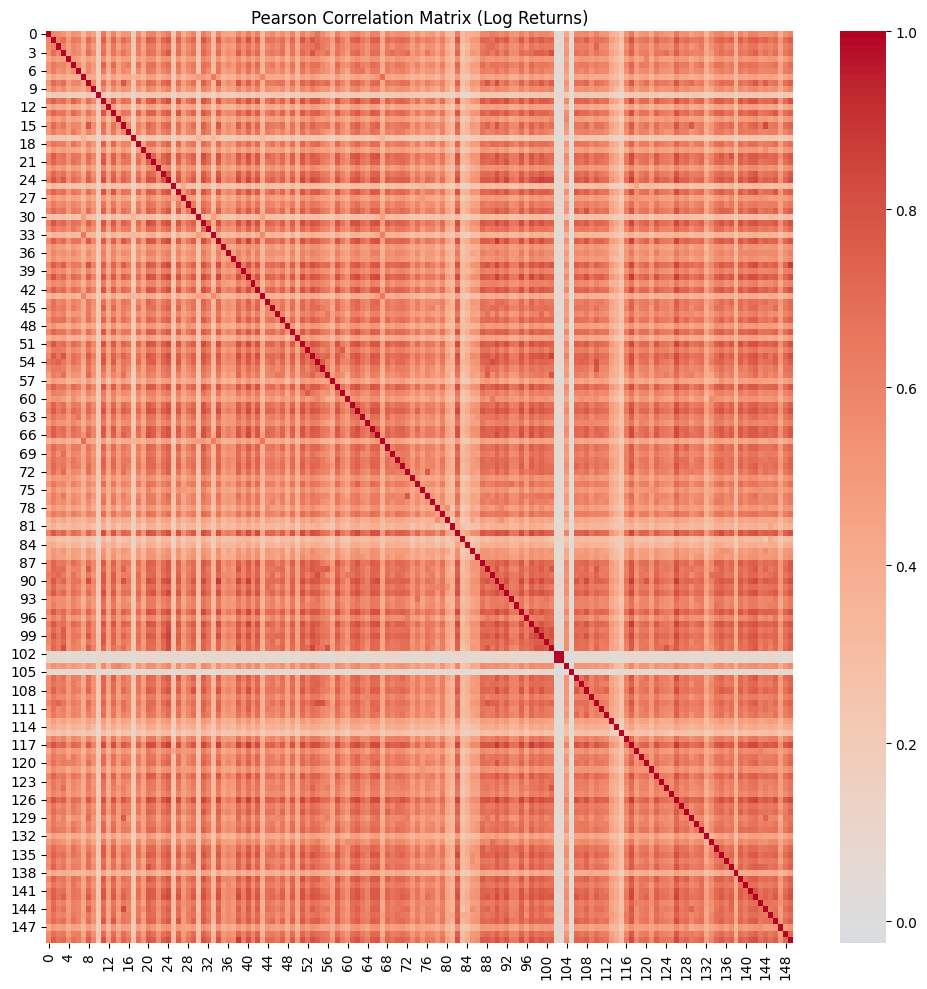

In [13]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Matrix (Log Returns)")
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/correlation_matrix.png", dpi=150)
plt.show()

### Student Interpretation

The correlation heatmap visually confirms block structure and highly co-moving groups.
This supports the motivation for correlation-based pruning in portfolio construction.


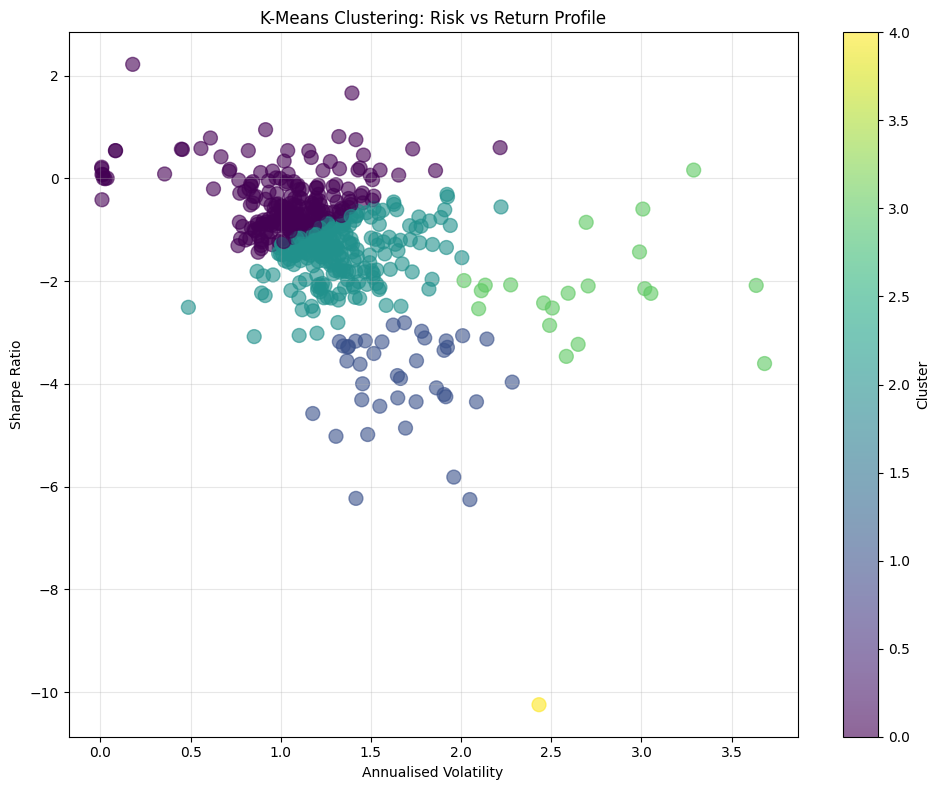

In [14]:
# K-Means scatter plot
_km = clustered.select("annual_vol", "sharpe", "cluster").collect()
_vols = [float(r["annual_vol"]) for r in _km]
_sharpes = [float(r["sharpe"]) for r in _km]
_clusters = [int(r["cluster"]) for r in _km]

plt.figure(figsize=(10, 8))
sc = plt.scatter(_vols, _sharpes, c=_clusters, cmap="viridis", s=100, alpha=0.6)
plt.xlabel("Annualised Volatility")
plt.ylabel("Sharpe Ratio")
plt.title("K-Means Clustering: Risk vs Return Profile")
plt.colorbar(sc, label="Cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/kmeans_clusters_viz.png", dpi=150)
plt.show()

### Student Interpretation

The cluster scatter plot shows how assets separate in risk-return space.
Even with overlap, we observe distinct regions, which justifies cluster-balanced portfolio selection.


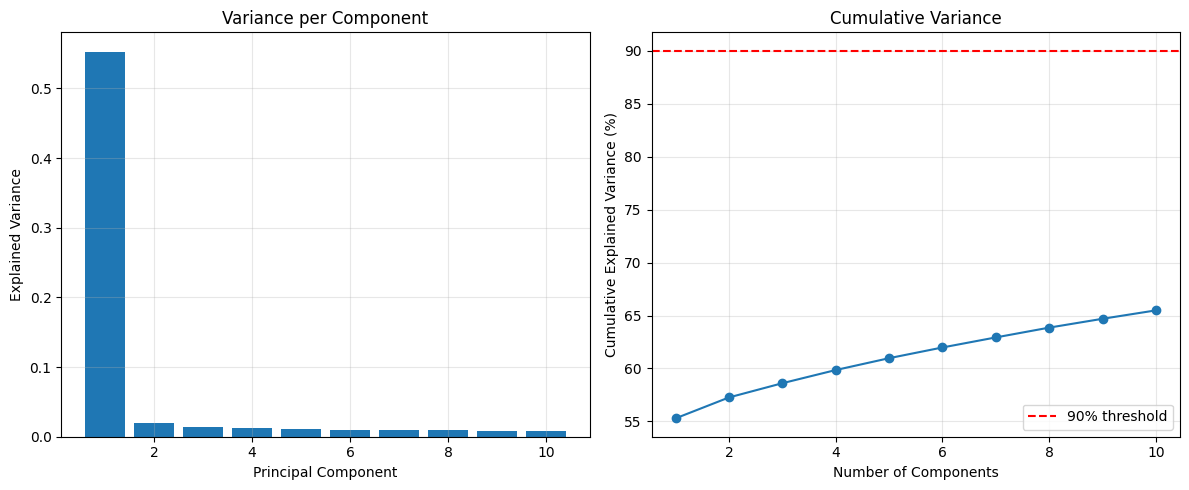

In [15]:
# PCA scree plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(range(1, len(explained_var) + 1), explained_var)
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance")
axes[0].set_title("Variance per Component")
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumsum_var) + 1), cumsum_var * 100, marker="o")
axes[1].axhline(y=90, color="r", linestyle="--", label="90% threshold")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance (%)")
axes[1].set_title("Cumulative Variance")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/pca_scree_plot.png", dpi=150)
plt.show()

### Student Interpretation

The scree plot confirms a dominant first component and diminishing marginal gains from higher PCs.
This is consistent with a market-factor interpretation plus smaller idiosyncratic factors.


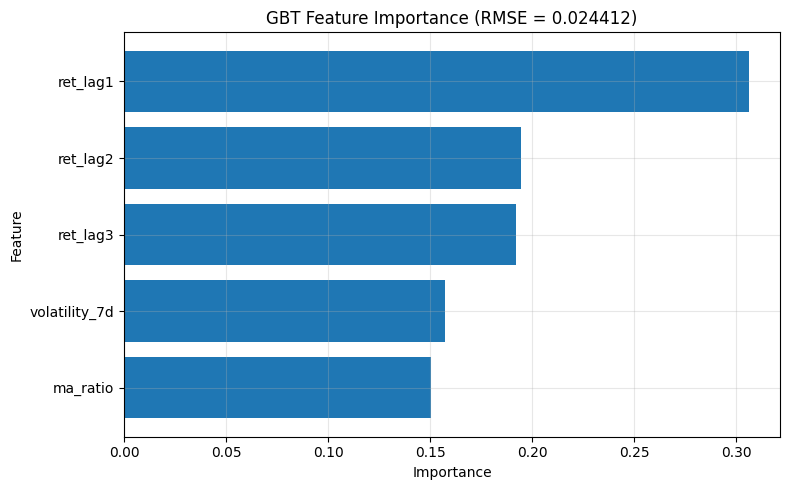

In [16]:
# GBT feature importance
_feats = [f for f, _ in feat_imp]
_imps = [v for _, v in feat_imp]

plt.figure(figsize=(8, 5))
plt.barh(_feats, _imps)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"GBT Feature Importance (RMSE = {rmse:.6f})")
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/gbt_feature_importance.png", dpi=150)
plt.show()

### Student Interpretation

Feature importance indicates the model relies most on lagged-return dynamics, then volatility and moving-average structure.
This gives an interpretable signal decomposition rather than a black-box result only.


## 10. Save Results and Cleanup

In [17]:
def _spark_to_csv(sdf, path, columns=None):
    """Collect a small Spark DataFrame and write a single CSV."""
    cols = columns or sdf.columns
    rows = sdf.select(*cols).collect()
    with open(path, "w", newline="") as fh:
        writer = csv.writer(fh)
        writer.writerow(cols)
        for r in rows:
            writer.writerow([r[c] for c in cols])
    print(f"  Saved: {path}")

print("Saving outputs ...")
_spark_to_csv(portfolio, f"{OUTPUT_FOLDER}/smart_index.csv",
              ["symbol", "weight", "sharpe", "annual_vol"])
_spark_to_csv(
    clustered.select("symbol", "cluster", "sharpe", "annual_ret", "annual_vol"),
    f"{OUTPUT_FOLDER}/kmeans_clusters.csv",
)
_spark_to_csv(cluster_leaders, f"{OUTPUT_FOLDER}/kmeans_portfolio.csv")

with open(f"{OUTPUT_FOLDER}/pca_components.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["component", "explained_variance", "cumulative_variance"])
    for i in range(len(explained_var)):
        w.writerow([f"PC{i+1}", explained_var[i], cumsum_var[i]])
print(f"  Saved: {OUTPUT_FOLDER}/pca_components.csv")

with open(f"{OUTPUT_FOLDER}/gbt_feature_importance.csv", "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["feature", "importance"])
    for feat, imp in feat_imp:
        w.writerow([feat, imp])
print(f"  Saved: {OUTPUT_FOLDER}/gbt_feature_importance.csv")

print("\nAll outputs saved to:", OUTPUT_FOLDER)

Saving outputs ...
  Saved: output/smart_index.csv
  Saved: output/kmeans_clusters.csv
  Saved: output/kmeans_portfolio.csv
  Saved: output/pca_components.csv
  Saved: output/gbt_feature_importance.csv

All outputs saved to: output


In [18]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
